## Table of Contents

1. [Introduction](#Introduction)
2. [Setup](#Setup)
   1. [Imports](#Imports)
   2. [Custom Functions](#Custom-Functions)
3. [Data](#Data)
   1. [Data Loading](#Data-Loading)
   2. [Data Processing](#Data-Processing)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
   1. [Feature count](#Feature-count)
   2. [Numpy array representation](#Numpy-Array-Representation)
5. [Model Exploration](#Model-Exploration)
   1. [Filter by feature count](#Filter-By-Feature-Count)
   2. [Filter by text match](#filter-by-text-match)
   3. [Filter by wall color](#filter-by-wall-color)
   4. [Filter by door color](#filter-by-door-color)
6. [Evaluation Metrics](#Evaluation-Metrics)
   1. [Evalutations for feature count](#evaluations-for-feature-count)
7. [Summary](#Summary)

## Introduction

## Setup

This section is for configuration, imports and utilities.

### Imports

Import necessary Python packages.

- os for filesystem crawling
- cv2 for computer vision functions
- numpy for general matrix handling
- matplotlib for visualizing results
- importlib for relading python modules

In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import importlib

print("Numpy version:", np.__version__)
print("OpenCV version:", cv2.__version__)

Numpy version: 1.26.3
OpenCV version: 4.6.0


### Custom-Functions

Import custom functions.

In [66]:
import sys
sys.path.append("..")

# Add Python modules here which you are working with, so that you can reload them
# without need of restarting the kernel.
import src.evaluation as evaluation
import src.count_features as count_features
import src.extract_color as extract_color
import src.load_data as load_data
import src.crop_images as crop_images
import src.texture_analysis as texture_analysis
_ = importlib.reload(extract_color)
_ = importlib.reload(evaluation)
_ = importlib.reload(count_features)
_ = importlib.reload(load_data)
_ = importlib.reload(crop_images)
_ = importlib.reload(texture_analysis)

In [72]:
from src.count_features import draw_bounding_boxes, compute_feature_counts, filter_by_feature_count
from src.evaluation import evaluate_filter_functions
from src.extract_color import extract_color,euclidean_Dist,filter_by_color,evaluate_filter_by_color
from src.load_data import load_and_process_eTRIMS
from src.crop_images import crop,cropping_images_annotaions
from src.texture_analysis import create_lbp_dict, visualize_lbp, calculate_kullback_leibler_divergence_scores, visualize_scores

## Data

This section is for the data loading and processing.

### Data Loading

In [4]:
eTRIMS_annotations_folder = "../data/etrims-db_v1/annotations_08etrims-ds"
eTRIMS_images_folder = "../data/etrims-db_v1/images_08_etrims-ds"

- Load eTRIMS images and annotations to dicts
- By default, the colours in cv.imread and matplotlib are in different order (BRG vs RGB), so account for that

In [5]:
eTRIMS_images = {}
eTRIMS_annotations = {}

for filename in os.listdir(eTRIMS_images_folder):
    name = filename[:-4]
    eTRIMS_images[name] = cv2.imread(eTRIMS_images_folder + "/" + filename)[...,::-1]
    eTRIMS_annotations[name] = cv2.imread(eTRIMS_annotations_folder + "/" + name + ".png")[...,::-1]

- Visualize to show types of data

<Figure size 640x480 with 0 Axes>

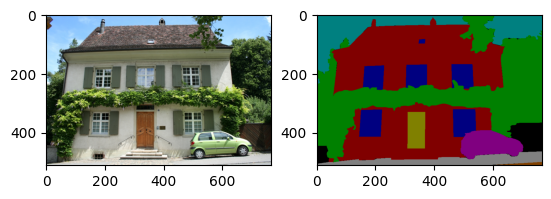

In [6]:
plt.figure()
# rows, columns
f, axarr = plt.subplots(1,2)

axarr[0].imshow(list(eTRIMS_images.values())[0])
axarr[1].imshow(list(eTRIMS_annotations.values())[0])
plt.show()

### Data Processing

- Figure out masks for different annotations, and related classes

[[  0   0   0]
 [  0   0 128]
 [  0 128   0]
 [  0 128 128]
 [128   0   0]
 [128   0 128]
 [128  64   0]
 [128 128   0]
 [128 128 128]]


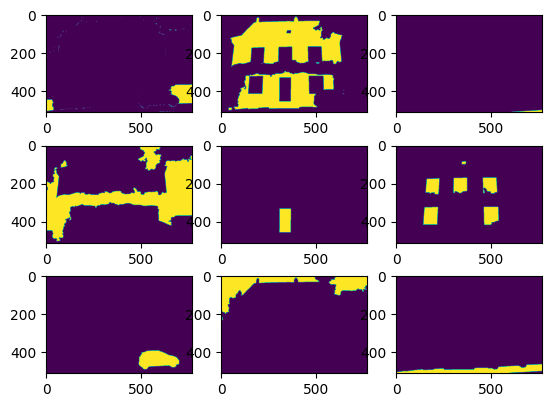

In [7]:
print(np.unique(list(eTRIMS_annotations.values())[0].reshape(-1,3),axis=0))
eTRIMS_none = [0,0,0]
eTRIMS_building = [128,0,0]
eTRIMS_road = [128,64,0]
eTRIMS_foliage = [0,128,0]
eTRIMS_door = [128,128,0]
eTRIMS_window = [0,0,128]
eTRIMS_vehicle = [128,0,128]
eTRIMS_sky = [0,128,128]
eTRIMS_pavement = [128,128,128]

f, axarr = plt.subplots(3,3)
axarr[0][0].imshow((list(eTRIMS_annotations.values())[0]==eTRIMS_none).all(axis=2))
axarr[0][1].imshow((list(eTRIMS_annotations.values())[0]==eTRIMS_building).all(axis=2))
axarr[0][2].imshow((list(eTRIMS_annotations.values())[0]==eTRIMS_road).all(axis=2))
axarr[1][0].imshow((list(eTRIMS_annotations.values())[0]==eTRIMS_foliage).all(axis=2))
axarr[1][1].imshow((list(eTRIMS_annotations.values())[0]==eTRIMS_door).all(axis=2))
axarr[1][2].imshow((list(eTRIMS_annotations.values())[0]==eTRIMS_window).all(axis=2))
axarr[2][0].imshow((list(eTRIMS_annotations.values())[0]==eTRIMS_vehicle).all(axis=2))
axarr[2][1].imshow((list(eTRIMS_annotations.values())[0]==eTRIMS_sky).all(axis=2))
axarr[2][2].imshow((list(eTRIMS_annotations.values())[0]==eTRIMS_pavement).all(axis=2))

## Exploratory Data Analysis

This section is for the EDA.

### Feature count

This section is to visualize and evaluate feature count properties, such as drawing bounding boxes by certain feature (window, door etc.) and to calculate number of bounding boxes.

- Select example annotations (one for windows and one for doors)
- Compute number door and window bounding boxes on each annotation and store their results into dictionary
- Draw bounding boxes on top of the selected example annotations.

In [8]:
number_of_door_boxes = compute_feature_counts(eTRIMS_annotations, eTRIMS_door)
number_of_window_boxes = compute_feature_counts(eTRIMS_annotations, eTRIMS_window)

berlin11_annotation = eTRIMS_annotations["berlin_000011"]
berlin11_image = eTRIMS_images["berlin_000011"]

basel70_annotation = eTRIMS_annotations["basel_000070_mv0"]
basel70_image = eTRIMS_images["basel_000070_mv0"]

window_bounding_boxes = draw_bounding_boxes(berlin11_annotation, eTRIMS_window)
door_bounding_boxes = draw_bounding_boxes(basel70_annotation, eTRIMS_door)

AttributeError: 'numpy.ndarray' object has no attribute 'masks'

- Vizualize bounding boxes for windows and original image

*NOTE: There are few additional boxes on top of certain window because they are partially covered by a foliage.*

In [ ]:
print("Number of window bounding boxes:", number_of_window_boxes["berlin_000011"])

f, axarr = plt.subplots(1,2)
axarr[0].imshow(window_bounding_boxes)
axarr[1].imshow(berlin11_image)
plt.show()

NameError: name 'number_of_window_boxes' is not defined

- Vizualize bounding boxes for doors and original image

*NOTE: There are 3 boxes on top of single door due vegetation. This may lead into big in accuracies since there are typically not many doors in a single facade.*

Number of door bounding boxes: 3


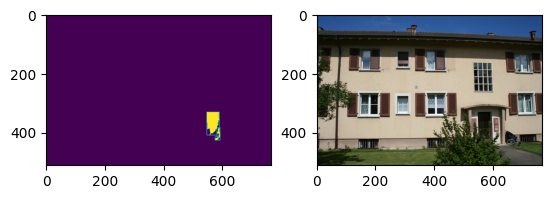

In [ ]:
print("Number of door bounding boxes:", number_of_door_boxes["basel_000070_mv0"])

f, axarr = plt.subplots(1,2)
axarr[0].imshow(door_bounding_boxes)
axarr[1].imshow(basel70_image)
plt.show()

### Numpy array representation

- One thing worth noting: x and y are reversed in the numpy array representation of the image

(768, 511)


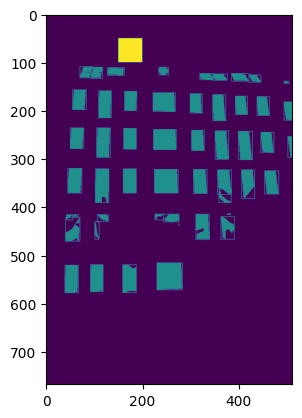

In [ ]:
print(window_bounding_boxes.shape)
window_bounding_boxes[50:100,150:200] = 2
plt.imshow(window_bounding_boxes)

## Model Exploration

This section is for the creation and exploration of different model.

### Filter by feature count

This section is for counting the number of certain features on a image.

- Count the number of windows on all annotations and compare them into target annotation.
- Create list of tuples (key, distance) from the closest candidate to the furthest.
- Show three closest candidates.

In [ ]:
filtered_by_windows = filter_by_feature_count("berlin_000011", eTRIMS_annotations, eTRIMS_window)

print("Number of windows (bounding boxes) on target image (berlin_000011):", number_of_window_boxes["berlin_000011"])

print("TOP3 candidates:")
for annotation in filtered_by_windows[:3]:
  print(f"Image key: {annotation[0]} | Difference: {annotation[1]}")

Number of windows (bounding boxes) on target image (berlin_000011): 51
TOP3 candidates:
Image key: berlin_000011 | Difference: 0
Image key: prague_000002 | Difference: 3
Image key: berlin_000044 | Difference: 8


- Show target image and three closest candidates

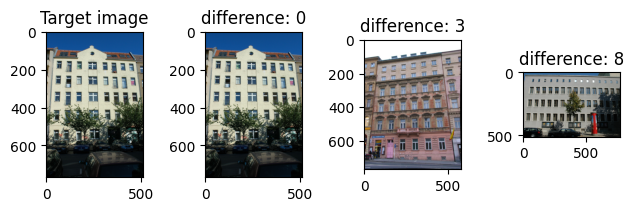

In [ ]:
f, axarr = plt.subplots(1,4)

axarr[0].imshow(eTRIMS_images["berlin_000011"])
axarr[0].set_title("Target image")

for i in range(3):
    axarr[i+1].imshow(eTRIMS_images[filtered_by_windows[i][0]])
    axarr[i+1].set_title(f"difference: {filtered_by_windows[i][1]}")

plt.tight_layout()
plt.show()

- Count the number of doors on all annotations and compare them into target annotation.
- Create list of tuples (key, distance) from the closest candidate to the furthest.
- Show ten closest candidates.

*NOTE: in this example, target image has only 1 door (but the number is computed as 3 doors). Therefore this method is not capable of finding closest images even though it finds closes images with 3 bounding boxes*

In [ ]:
filtered_by_doors = filter_by_feature_count("basel_000070_mv0", eTRIMS_annotations, eTRIMS_door)

print("Number of doors (bounding boxes) on target image (basel_000070):", number_of_door_boxes["basel_000070_mv0"])

for annotation in filtered_by_doors[:10]:
  print(f"Image key: {annotation[0]} | Difference: {annotation[1]}")

Number of doors (bounding boxes) on target image (basel_000070): 3
Image key: bonn_000015 | Difference: 0
Image key: prague_000002 | Difference: 0
Image key: basel_000070_mv0 | Difference: 0
Image key: basel_000049_mv0 | Difference: 0
Image key: uk_000129 | Difference: 0
Image key: basel_000058_mv0 | Difference: 0
Image key: basel_000052_mv0 | Difference: 0
Image key: heidelberg_000022_mv0 | Difference: 1
Image key: berlin_000056 | Difference: 1
Image key: bonn_000009 | Difference: 1


Show target image and three closest candidates (all has 0 difference).

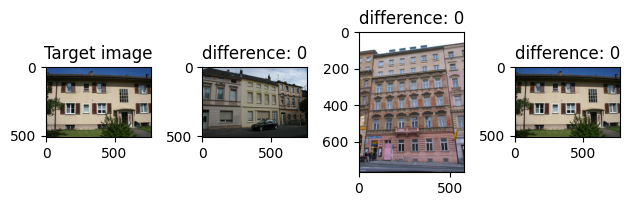

In [ ]:
f, axarr = plt.subplots(1,4)

axarr[0].imshow(eTRIMS_images["basel_000070_mv0"])
axarr[0].set_title("Target image")

for i in range(3):
    axarr[i+1].imshow(eTRIMS_images[filtered_by_doors[i][0]])
    axarr[i+1].set_title(f"difference: {filtered_by_doors[i][1]}")

plt.tight_layout()
plt.show()

### Filter by text match

Install PaddlePaddle:
```
python -m pip install paddlepaddle -i https://pypi.tuna.tsinghua.edu.cn/simple
pip install "paddleocr>=2.0.1" # Recommend to use version 2.0.1+
```

Steps:

1. **Text Recognition with PaddleOCR**:
   - First, run OCR on the newly inputted image to extract text content from the image.

2. **Load Previously Saved OCR Results**:
   - Load the JSON file containing OCR results from all previously processed images.

3. **Text Matching Search**:
   - For the text extracted from the input image, search the previously saved OCR results for images containing similar text content through simple text matching or more complex text similarity comparison methods.

4. **Output Matched Results**:
   - Output a list of images whose text content matches or is related to the text content of the input image.

To get json file, run the following command:
```
python ../src/ocr.py
```
It uses PaddleOCR for text detection and recognition of each image file, and saves the identified text information to json.

In [ ]:
from paddleocr import PaddleOCR
import json

# Assume that this is the original image path that you entered
input_image_path = '../data/etrims-db_v1/images_08_etrims-ds/prague_000002.jpg'

# OCR结果的保存路径
ocr_results_json_path = '../data/etrims-db_v1/ocr_results.json'

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en', show_log=False) #to prevent logs to pushed into remote

# Perform OCR text recognition on input images
input_image_ocr_result = ocr.ocr(input_image_path, cls=True)

# Extracts the text content of the input image
input_image_texts = [line[1][0] for line in input_image_ocr_result[0]]

# Load json file
with open(ocr_results_json_path, 'r', encoding='utf-8') as f:
    saved_ocr_results = json.load(f)

# Define a function to compare text similarity
def match_texts(input_texts, saved_texts):
    # Simple matching logic: Check whether any keywords in the input text appear in the saved text
    return any(input_text in saved_text for saved_text in saved_texts for input_text in input_texts)

# Search
matched_images = []
for image_name, ocr_data in saved_ocr_results.items():
    saved_texts = [item['text'] for item in ocr_data]
    if match_texts(input_image_texts, saved_texts):
        matched_images.append(image_name)

# Output the matched image name
print("Matched images:", matched_images)


Matched images: ['prague_000002.jpg']


### Filter by Wall Color

Steps:

1. Extracted wall color of all images in the data set using the mask that holds "building" label and stored the name of image and wall color in Dictionary.

2. Extracted the wall color of the test image.

3. Calculated euclidean distance between the wall color of test image and the wall color of other images in the data set.

4. Sorted the images based on the euclidean distance and dislpayed the top 3 images with the minimum euclidean distance. The true image has the minimum euclidean distance from the wall color of test image.



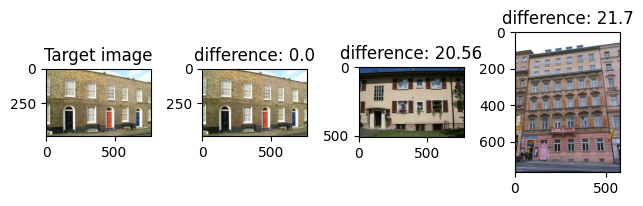

In [9]:
image_data=load_and_process_eTRIMS(eTRIMS_annotations_folder,eTRIMS_images_folder)
sorted_wall_color_distances=filter_by_color("uk_000129",image_data,"building",None)
f, axarr = plt.subplots(1,4)
axarr[0].imshow(eTRIMS_images["uk_000129"])
axarr[0].set_title("Target image")

for i in range(3):
    axarr[i+1].imshow(eTRIMS_images[list(sorted_wall_color_distances.keys())[i]])
    axarr[i+1].set_title(f"difference: {round(list(sorted_wall_color_distances.values())[i],2)}")

plt.tight_layout()
plt.show()


### Filter by door Color

Steps:

1. Extracted door color of all images in the data set using the mask that holds "door" label and stored the name of image and door color in Dictionary.

2. Extracted the door color of the test image.

3. Calculated euclidean distance between the door color of test image and the door color of other images in the data set.

4. Sorted the images based on the euclidean distance and dislpayed the top 3 images with the minimum euclidean distance. The true image has the minimum euclidean distance from the door color of test image.


In [10]:
sorted_door_color_distances=filter_by_color("uk_000129",image_data,"door")
f, axarr = plt.subplots(1,4)
axarr[0].imshow(eTRIMS_images["uk_000129"])
axarr[0].set_title("Target image")

for i in range(3):
    axarr[i+1].imshow(eTRIMS_images[list(sorted_door_color_distances.keys())[i]])
    axarr[i+1].set_title(f"difference: {round(list(sorted_door_color_distances.values())[i],2)}")

plt.tight_layout()
plt.show()

TypeError: filter_by_color() missing 1 required positional argument: 'quarters'

#### Filter By wall Color on Cropped Images

First, we have cropped all the images and their respective annotations into quarters.

In [ ]:
Quarter1,Quarter2,Quarter3,Quarter4=cropping_images_annotaions(image_data)

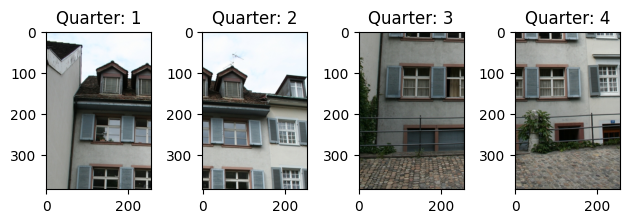

In [ ]:
f, axarr = plt.subplots(1,4)
axarr[0].imshow(Quarter1["basel_000049_mv0"].image)
axarr[0].set_title(f"Quarter: {1}")
axarr[1].imshow(Quarter2["basel_000049_mv0"].image)
axarr[1].set_title(f"Quarter: {2}")
axarr[2].imshow(Quarter3["basel_000049_mv0"].image)
axarr[2].set_title(f"Quarter: {3}")
axarr[3].imshow(Quarter4["basel_000049_mv0"].image)
axarr[3].set_title(f"Quarter: {4}")

plt.tight_layout()
plt.show()

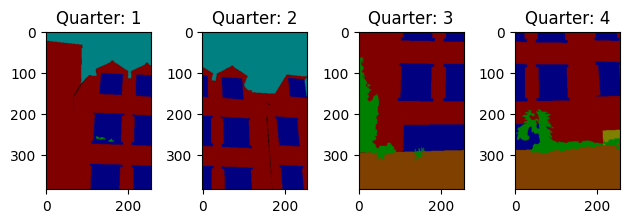

In [ ]:
f, axarr = plt.subplots(1,4)
axarr[0].imshow(Quarter1["basel_000049_mv0"].annotation)
axarr[0].set_title(f"Quarter: {1}")
axarr[1].imshow(Quarter2["basel_000049_mv0"].annotation)
axarr[1].set_title(f"Quarter: {2}")
axarr[2].imshow(Quarter3["basel_000049_mv0"].annotation)
axarr[2].set_title(f"Quarter: {3}")
axarr[3].imshow(Quarter4["basel_000049_mv0"].annotation)
axarr[3].set_title(f"Quarter: {4}")

plt.tight_layout()
plt.show()

Now, we will apply wall color filtering on the cropped images for all quarters

TypeError: Image data of dtype object cannot be converted to float

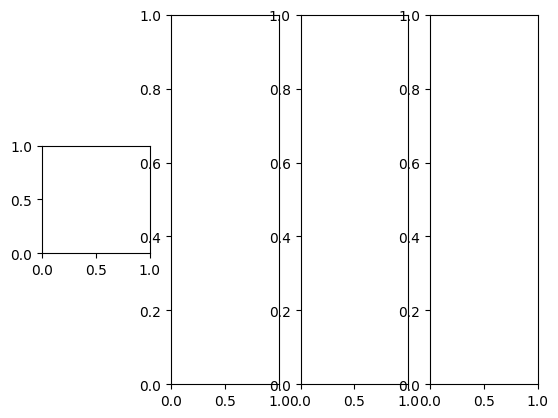

In [ ]:
sorted_wall_color_distances=filter_by_color("basel_000049_mv0",image_data,"building",Quarter1)
f, axarr = plt.subplots(1,4)
axarr[0].imshow(Quarter1["basel_000049_mv0"].image)
axarr[0].set_title("Target image")

for i in range(3):
    axarr[i+1].imshow(eTRIMS_images[list(sorted_wall_color_distances.keys())[i]])
    axarr[i+1].set_title(f"difference: {round(list(sorted_wall_color_distances.values())[i],2)}")

plt.tight_layout()
plt.show()

### Filter by building texture

In [69]:
image_name = 'bonn_000047'
masks = ['building', 'window', 'door']

# LBP settings
radius = 2
n_points = 8 * radius

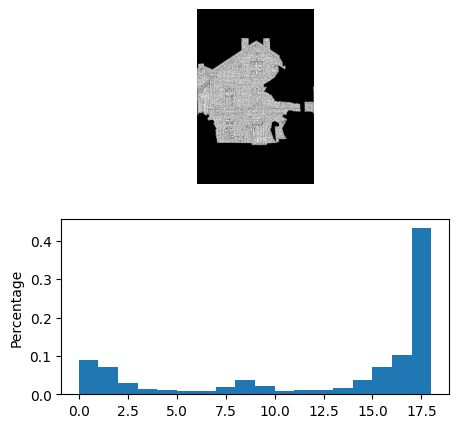

In [70]:
lbp_dict = create_lbp_dict(image_data, radius, n_points)
lbp = lbp_dict[image_name]
visualize_lbp(lbp, image_data, image_name, masks=masks)

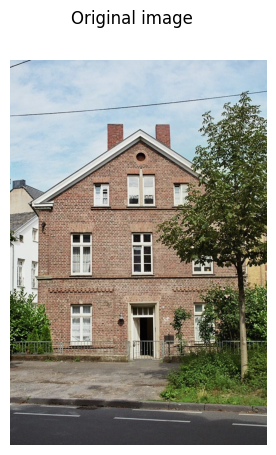

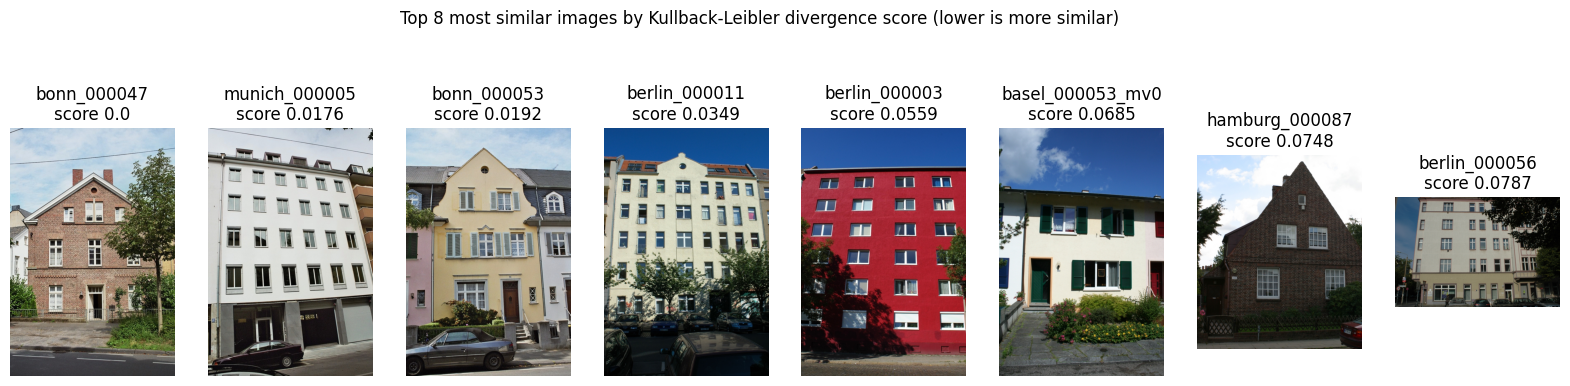

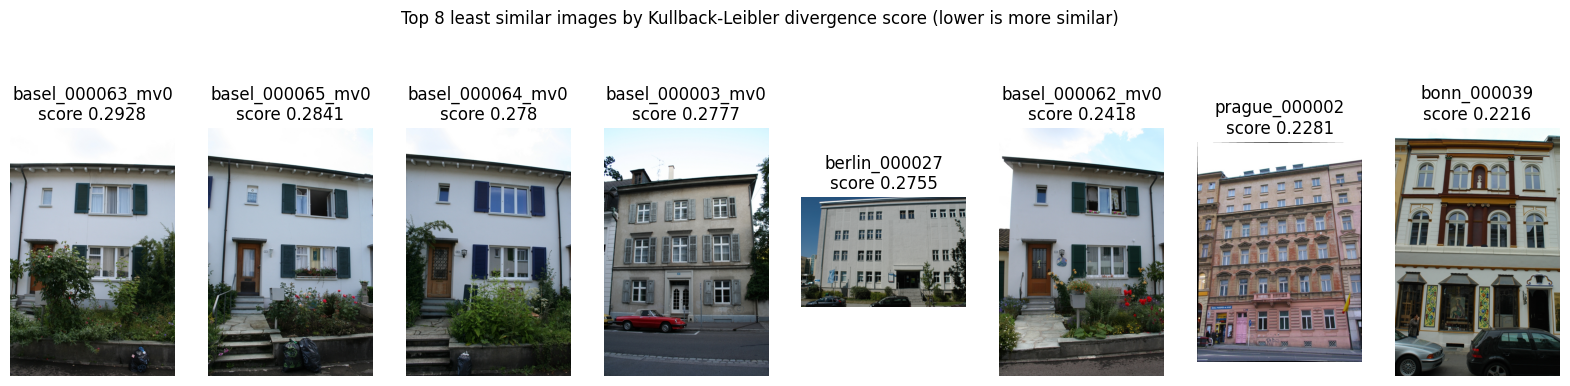

In [73]:
score_dict = calculate_kullback_leibler_divergence_scores(image_data, lbp_dict, image_name, masks=masks)
visualize_scores(score_dict, image_data, image_name)

## Evaluation Metrics

This section is for measuring of model performances.

### Evaluations for feature count

Measure execution time and accuracy with different number of filtering tresholds. Evaluation individual filtering methods can help to determine in which order and what tresholds should be used for filtering.

#### Evaluate window count

Run evaluate function to retrieve print summary of:
- The minimum number of candidates (N) required such that the correct label is always included in the results.
- A list of execution times for the filter_function, measured for each annotation in the dataset.
- A dictionary mapping each top N value distribution when correct label is included in the results.

In [ ]:
window_count_evaluation = evaluate_filter_functions(filter_by_feature_count, eTRIMS_annotations, eTRIMS_window)

min_candidates_window = window_count_evaluation["min_candidates_needed"]
execution_times_window = window_count_evaluation["execution_times"]
top_n_window = window_count_evaluation["top_n_distribution"]

In [ ]:
print(f"Min candidates needed to ensure 100% accuracy: {min_candidates_window}")
print(f"Average execution time: {sum(execution_times_window) / len(execution_times_window):.3f} seconds")
print("TOP5 candidate accuracy:")

for i in range(1, 6):
  print(f"TOP{i}: {top_n_window[i]*100:.2f} %")

Min candidates needed to ensure 100% accuracy: 6
Average execution time: 1.157 seconds
TOP5 candidate accuracy:
TOP1: 51.67 %
TOP2: 80.00 %
TOP3: 93.33 %
TOP4: 96.67 %
TOP5: 98.33 %


Plot distribution for window counting accuracy depending from the number of candidates. 

*This means for example, that 80% of times window counting returns correct label out of 2 candidates and everytime correct label is one of the TOP6 candidate.*

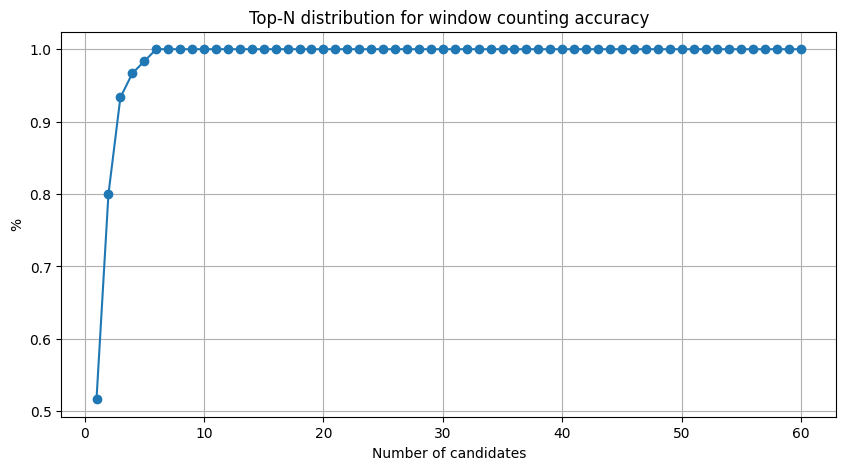

In [ ]:
top_n_values = list(top_n_window.keys())
distribution_values = list(top_n_window.values())

plt.figure(figsize=(10, 5))
plt.plot(top_n_values, distribution_values, marker="o")

plt.title("Top-N distribution for window counting accuracy")
plt.xlabel("Number of candidates")
plt.ylabel("%")

plt.grid(True)
plt.show()

#### Evaluate door count

In [ ]:
door_count_evaluation = evaluate_filter_functions(filter_by_feature_count, eTRIMS_annotations, eTRIMS_door)

min_candidates_door = door_count_evaluation["min_candidates_needed"]
execution_times_door = door_count_evaluation["execution_times"]
top_n_door = door_count_evaluation["top_n_distribution"]

In [ ]:
print(f"Min candidates needed to ensure 100% accuracy: {min_candidates_door}")
print(f"Average execution time: {sum(execution_times_door) / len(execution_times_door):.3f} seconds")
print("TOP5 candidate accuracy:")

for i in range(1, 6):
    print(f"TOP{i}: {top_n_door[i]*100:.2f} %")

Min candidates needed to ensure 100% accuracy: 24
Average execution time: 1.254 seconds
TOP5 candidate accuracy:
TOP1: 10.00 %
TOP2: 16.67 %
TOP3: 23.33 %
TOP4: 30.00 %
TOP5: 36.67 %


Plot distribution for door counting accuracy depending from the number of candidates. 

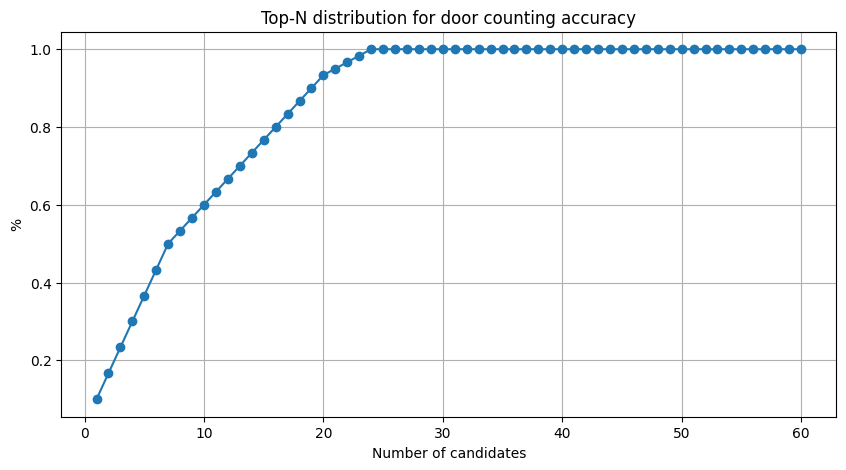

In [ ]:
top_n_values = list(top_n_door.keys())
distribution_values = list(top_n_door.values())

plt.figure(figsize=(10, 5))
plt.plot(top_n_values, distribution_values, marker="o")

plt.title("Top-N distribution for door counting accuracy")
plt.xlabel("Number of candidates")
plt.ylabel("%")

plt.grid(True)
plt.show()

#### Evaluate Wall color

In [ ]:
wall_color_evaluation=evaluate_filter_by_color(image_data,"building")
Correctly_Recognized_bywallcolor=wall_color_evaluation["Correctly_recognized_images"]
execution_time_wallcolor= wall_color_evaluation["execution_times"] 

print(f"Correctly Recognized images: {Correctly_Recognized_bywallcolor}")

print(f"Average execution time: {sum(execution_time_wallcolor) / len(execution_time_wallcolor):.3f} seconds")
print(f"Accuracy:{Correctly_Recognized_bywallcolor/len(eTRIMS_images)}")


Correctly Recognized images: 60
Average execution time: 1.057 seconds
Accuracy:1.0


#### Evaluate door color

In [ ]:
door_color_evaluation=evaluate_filter_by_color(image_data,"door")
Correctly_Recognized_bydoorcolor=door_color_evaluation["Correctly_recognized_images"]
execution_time_doorcolor= door_color_evaluation["execution_times"] 

print(f"Correctly Recognized images: {Correctly_Recognized_bydoorcolor}")

print(f"Average execution time: {sum(execution_time_doorcolor) / len(execution_time_doorcolor):.3f} seconds")
print(f"Accuracy:{Correctly_Recognized_bydoorcolor/len(eTRIMS_images)}")


Correctly Recognized images: 54
Average execution time: 0.916 seconds
Accuracy:0.9


## Summary

This section is for the summary.

In [ ]:
# To be added.